# We reproduce results from section 6.4.2 in 'Spectroscopic Ellipsometry', by H. Fujiwara
Author: O. Castany, M. Müller

Verification of the code against results presented in Fujiwara's book
p. 241 (section 6.4.2). References in the comments refer to this book.
Expected results are indicated after the commands. They are identical
with Fujiwara's results, except for a sign convention for Erp.

In [1]:
import numpy as np
import berreman4x4 as bm
from scipy.constants import pi
import matplotlib.pyplot as pyplot
import scipy.linalg

# reduces the number of printed figures in numbers:
np.set_printoptions(suppress=True, precision=4)

## Example: Air / anisotropic film / silicon substrate

In [2]:
n_i = 1.0       # incident medium is air
n_o = 2.0       # ordinary index of thin layer
n_e = 2.5       # extraordinary index of thin layer
lbda = 620      # Wavelength for evaluation (nm)
Phi_i = 70      # 70° indicence angle (degree)
d = 100      # thin layer thickness (nm)
# Orientation of the anisotropy of the thin layer
Phi_E = 45      # 1st Euler angle
Theta_E = 45    # 2nd Eulet angle

## Permittivity tensor of the anisotropic film (eq 6.63, p. 241):

In [3]:
filmMaterial = bm.UniaxialMaterial(bm.DispersionLess(n_o),
                                      bm.DispersionLess(n_e))
R = bm.rotation_Euler((Phi_E, Theta_E, 0))
filmMaterial.setRotation(R)
print(filmMaterial.getTensor(lbda))

[[[ 4.5625+0.j -0.5625+0.j  0.7955+0.j]
  [-0.5625+0.j  4.5625+0.j -0.7955+0.j]
  [ 0.7955+0.j -0.7955+0.j  5.125 +0.j]]]


Should yield:
```python
[[[ 4.5625, -0.5625,  0.7955],
  [-0.5625,  4.5625, -0.7955],
  [ 0.7955, -0.7955,  5.125 ]]]
```

In [4]:
air = bm.IsotropicMaterial(bm.DispersionLess(n_i))
Kx = n_i * np.sin(np.deg2rad(Phi_i))

print("Kx: {:.4f}".format(Kx))

Kx: 0.9397


```python
Kx = 0.9397
```

In [5]:
film = bm.Layer(filmMaterial, d)
epsilon = filmMaterial.getTensor(lbda)
Delta = bm.Solver4x4.buildDeltaMatrix(Kx, epsilon)
print("\nDelta matrix:")
print(Delta)

q, Psi = scipy.linalg.eig(Delta[0])
print("\nEigenvalues of the Delta matrix (eq 6.64, p.241):")
print(np.real(q))


Delta matrix:
[[[-0.1459+0.j  0.1459-0.j  0.    +0.j  0.8277+0.j]
  [ 0.    +0.j  0.    +0.j -1.    +0.j  0.    +0.j]
  [ 0.439 +0.j -3.556 +0.j  0.    +0.j -0.1459+0.j]
  [ 4.439 +0.j -0.439 +0.j  0.    +0.j -0.1459+0.j]]]

Eigenvalues of the Delta matrix (eq 6.64, p.241):
[-2.174  -1.7655  1.7655  1.8822]


```python
# Delta matrix:
[[[-0.1459,  0.1459,  0.    ,  0.8277],
  [ 0.    ,  0.    , -1.    ,  0.    ],
  [ 0.439 , -3.556 ,  0.    , -0.1459],
  [ 4.439 , -0.439 ,  0.    , -0.1459]]]

# Eigenvalues of Delta
[-2.174 , -1.7655,  1.7655,  1.8822]
```

In [6]:
Tp = bm.PropagatorExpmScipy().calculate_propagation(Delta, -d, np.array([lbda]))
print("\nPropagation matrix (eq 6.66, p. 242):")
print(Tp)


Propagation matrix (eq 6.66, p. 242):
[[[-0.3516-0.0572j  0.0906-0.001j   0.0334+0.0437j  0.0561-0.3971j]
  [ 0.1042+0.0795j -0.3258-0.0114j  0.0037+0.5017j -0.0334-0.0437j]
  [ 0.1617-0.0145j -0.0166+1.7533j -0.3258-0.0114j -0.0906+0.001j ]
  [ 0.3001-2.1207j -0.1617+0.0145j -0.1042-0.0795j -0.3516-0.0572j]]]


```python
[[[-0.353-0.057j,  0.091-0.001j,  0.033+0.044j,  0.056-0.397j],
  [ 0.104+0.08j , -0.327-0.011j,  0.004+0.502j, -0.033-0.044j],
  [ 0.162-0.014j, -0.017+1.753j, -0.327-0.011j, -0.091+0.001j],
  [ 0.300-2.12j , -0.162+0.014j, -0.104-0.08j , -0.353-0.057j]]]
```

In [7]:
n_t = 3.898 + 0.016j  #  refractive index of substrate
silicon = bm.IsotropicMaterial(bm.DispersionLess(n_t))
s = bm.Structure(air, [film], silicon)
result = s.evaluate(np.array([lbda]), Phi_i)
#T = s.getStructureMatrix(Kx, k0)
#print("\nTransfer matrix T (eq 6.67, p. 242):")
#print(T)
"""                                                                 (eq 6.67)
Fujiwara uses the ellipsometry convention for the orientation of the 'p'
polarized electric fields (see figures 2.15 and 6.14). With my convention,
Erp is reversed. Consequently, T_{4j} and T_{i4} have a reversed sign, except
T_{44}.
T =
matrix([[-1.949-3.588j,  1.671-1.548j,  0.273-0.03j , -0.630+0.147j],
        [ 1.617+1.679j, -1.992+3.434j, -0.301-0.064j,  0.861+0.101j],
        [ 0.065-0.086j,  0.039+0.097j, -0.712-3.485j,  0.004+1.265j],
        [-0.167-0.403j,  0.593+0.386j,  0.370-1.199j, -1.662+3.093j]])
"""
Jr = result.jones_matrix_r  #  Jones reflexion matrix
print("\nJones reflexion matrix (p. 243):")
print(Jr)

print("\nEllipsometry parameters (p. 243):")
(Psi, Delta) = (result.psiMat, result.deltaMat)
print("Psi\n" + str(Psi))
print("Delta\n" + str(Delta))


Jones reflexion matrix (p. 243):
[[[ 0.3107+0.1606j  0.1067+0.0019j]
  [ 0.0422-0.0359j -0.5512+0.1507j]]]

Ellipsometry parameters (p. 243):
Psi
[[[31.4728 10.5742]
  [ 5.5361 45.    ]]]
Delta
[[[ -42.629   -16.3048]
  [-154.8662   -0.    ]]]


```python
Jr =
[[[ 0.310+0.161j,  0.107+0.002j],
  [ 0.042-0.036j, -0.552+0.151j]]]
#The first line, [r_pp, r_ps], has reversed sign compared to Fujiwara's result, due to the different convention for Erp.
Ellipsometry parameters:
Psi                         Delta
[[ 31.4419  10.5641]         [[ -42.734   -16.4123]
 [  5.5332  45.    ]]         [-155.024     0.    ]]
```

In [8]:
# We now reproduce figure 6.19:
print("\nWe reproduce figure 6.19, p. 242...")


We reproduce figure 6.19, p. 242...


In [9]:
Theta_E_list = [0, 45, 90]
Phi_E_list = np.linspace(0, 180, 36*2+1)

Psi_pp = []
Delta_pp = []
Psi_ps = []
Delta_ps = []

In [10]:
for Theta_E in Theta_E_list:
    for Phi_E in Phi_E_list:
        R = bm.rotation_Euler((Phi_E, Theta_E, 0))
        filmMaterial.setRotation(R)
        data = s.evaluate(np.array([lbda]), Phi_i)
        Psi_pp.append(data.psiMat[0,0,0])
        Delta_pp.append(data.deltaMat[0,0,0])
        Psi_ps.append(data.psiMat[0,0,1])
        Delta_ps.append(data.deltaMat[0,0,1])

In [11]:
Psi_pp = np.array(Psi_pp)
Psi_pp = Psi_pp.reshape(3, 73).T

Psi_ps = np.array(Psi_ps)
Psi_ps = Psi_ps.reshape(3, 73).T

Delta_pp = np.array(Delta_pp)
Delta_pp = Delta_pp.reshape(3, 73).T

Delta_ps = np.array(Delta_ps)
Delta_ps = Delta_ps.reshape(3, 73).T

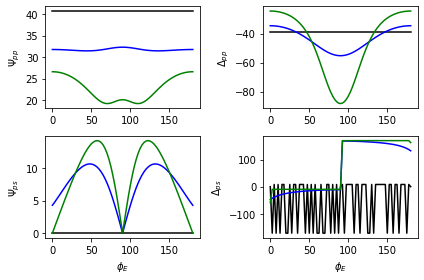

In [12]:
fig = pyplot.figure()
# Plot curves for the three values of Theta_E
pyplot.rcParams['axes.prop_cycle'] = pyplot.cycler('color', 'kbg')
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(Phi_E_list, Psi_pp)
ax1.set_ylabel(r"$\Psi_{pp}$")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(Phi_E_list, Delta_pp)
ax2.set_ylabel(r"$\Delta_{pp}$")

# Plot curves for two values of Theta_E
pyplot.rcParams['axes.prop_cycle'] = pyplot.cycler('color', 'kbg')
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(Phi_E_list, Psi_ps)
ax3.set_ylabel(r"$\Psi_{ps}$")
ax3.set_xlabel(r"$\phi_E$")

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(Phi_E_list, Delta_ps)
ax4.set_ylabel(r"$\Delta_{ps}$")
ax4.set_xlabel(r"$\phi_E$")

pyplot.tight_layout()
pyplot.show()